In [1]:
import joblib

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [4]:
import pandas as pd

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
tests = pd.read_csv("tests.csv",delimiter=";")

In [7]:
tests.head()

,Product Code,The Measured Energy Ventilated Consumption,Declerated EEI,Measured Volume,Test Function,For 230V Total Working Cycle Power,Pulsation,Function Type,Buffle,Insulation Desc. Kg/m^3,Thermal Conductivity (W/mK),Cooling Fan Poer,Cooling fan Type ( T=tangetial fan)/R=radial fan),Cooling Fan RPM,Cavity Fan RPM,Number of glass,Cavity Type (F=Flat/E= Embossed),Ventilation Channel,Chimney (0: No/1:Yes)
0,33703472,0.68,A+,69.4,Cooklight,2410,Pulsation,Multifunction,New ECO,33,0.064,12.0,R,1100.0,1800,2,F,Ventilation Channel,1
1,33703472,0.68,A+,69.4,Cooklight,2410,Pulsation,Multifunction,New ECO,33,0.064,12.0,R,1100.0,1800,2,F,Ventilation Channel,1
2,33703472,0.68,A+,69.4,Cooklight,2410,Pulsation,Multifunction,New ECO,33,0.064,12.0,R,1100.0,1800,2,F,Ventilation Channel,1
3,33703472,0.72,A+,69.4,Cooklight,2410,Pulsation,Multifunction,New ECO,33,0.064,12.0,R,1100.0,1800,2,F,Ventilation Channel,1
4,33703472,0.72,A+,69.4,Cooklight,2410,Pulsation,Multifunction,New ECO,33,0.064,12.0,R,1100.0,1800,2,F,Ventilation Channel,1


## Importing the Preprocessor

In [8]:
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.columns)


In [9]:
preprocessor = joblib.load("preprocessor.joblib")

In [10]:
preprocessor

ColumnTransformer(transformers=[('Drop Product Code',
                                 DropColumns(columns=['Product Code ']),
                                 ['Product Code ']),
                                ('Ventilation Channel',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='No '
                                                                           'Ventilation '
                                                                           'Channel',
                                                                strategy='constant')),
                                                 ('One hot encode',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Ventilation Channel ']),
                                ('Cooling Fan Type',
                                 Pipeline(steps=[('impu...
                                 ['Cooling fan Type ( T=tangetial '
                                  'fan)/R=radial fan)']),
                                ('Cooling Fan Power and Cooling Fan RPM',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'))]),
                                 ['Cooling Fan Poer ', 'Cooling Fan RPM']),
                                ('Other Categorical Columns To Be Encoded',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Test Function ', 'Pulsation ', 'Buffle ',
                                  'Cavity Type  (F=Flat/E= Embossed)'])])

# Data Split

In [11]:
X = tests.drop(['The Measured Energy Ventilated Consumption',
       'Declerated EEI'],axis=1)

In [12]:
y = tests['Declerated EEI']

In [13]:
X = preprocessor.fit_transform(X)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
from sklearn.metrics import accuracy_score

In [17]:
import numpy as np

## Tuning The Hyperparameters 

In [18]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['log2', 'sqrt']
}

In [19]:
rf_classifier = RandomForestClassifier()

In [20]:
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5,verbose=1,error_score="raise")

In [21]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


GridSearchCV(cv=5, error_score='raise', estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=1)

In [22]:
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [23]:
best_rf_classifier = RandomForestClassifier(**best_params)

In [24]:
best_rf_classifier.fit(X_train,y_train)

RandomForestClassifier(max_features='log2', n_estimators=200)

In [25]:
y_train_pred = best_rf_classifier.predict(X_train)
validation_score = accuracy_score(y_train, y_train_pred)
print("Training set Accuracy: " + str(validation_score))

y_test_pred = best_rf_classifier.predict(X_test)
validation_score = accuracy_score(y_test, y_test_pred)
print("Test set Accuracy: " + str(validation_score))

Training set Accuracy: 0.91
Test set Accuracy: 0.9473684210526315


## Model Result

In [26]:
from sklearn.metrics import classification_report, confusion_matrix

In [33]:
import matplotlib.pyplot as plt

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay,RocCurveDisplay,PrecisionRecallDisplay

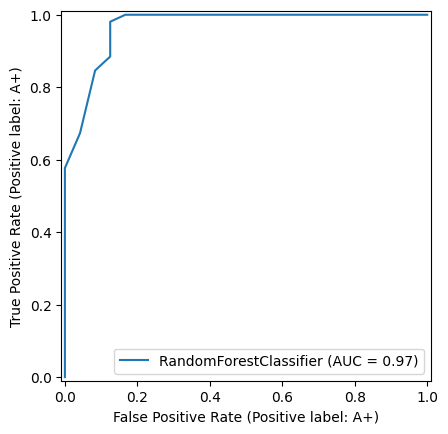

In [41]:
RocCurveDisplay.from_estimator(best_rf_classifier,X_test,y_test)
plt.show()

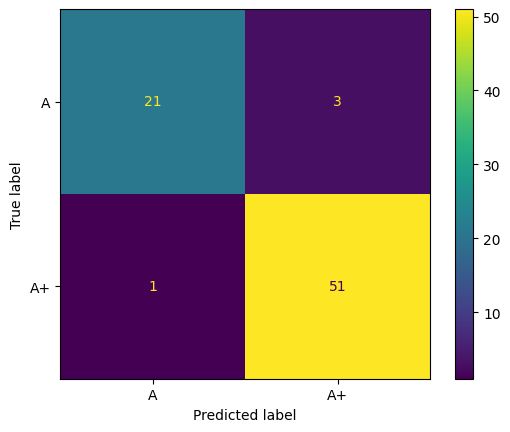

In [38]:
ConfusionMatrixDisplay.from_estimator(best_rf_classifier,X_test,y_test)
plt.show()

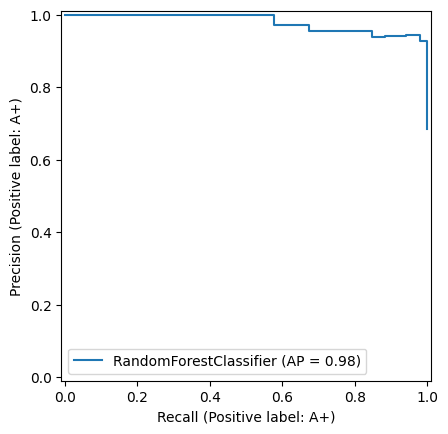

In [39]:
PrecisionRecallDisplay.from_estimator(best_rf_classifier,X_test,y_test)
plt.show()

In [42]:
print("Training set classification report")
print(classification_report(y_train,y_train_pred))

Training set classification report
              precision    recall  f1-score   support

           A       0.97      0.82      0.89       137
          A+       0.87      0.98      0.92       163

    accuracy                           0.91       300
   macro avg       0.92      0.90      0.91       300
weighted avg       0.92      0.91      0.91       300



In [43]:
print("Training set confusion matrix")
print(confusion_matrix(y_train,y_train_pred))

Training set confusion matrix
[[113  24]
 [  3 160]]


In [44]:
print("Test set classification report")
print(classification_report(y_test,y_test_pred))

Test set classification report
              precision    recall  f1-score   support

           A       0.95      0.88      0.91        24
          A+       0.94      0.98      0.96        52

    accuracy                           0.95        76
   macro avg       0.95      0.93      0.94        76
weighted avg       0.95      0.95      0.95        76



In [45]:
print("Test set confusion matrix")
print(confusion_matrix(y_test,y_test_pred))

Test set confusion matrix
[[21  3]
 [ 1 51]]


# Saving the Model

In [ ]:
#joblib.dump(best_rf_classifier,"Random Forest Classifier.joblib")